In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Lambda,Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import backend as K
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import os
import gzip
from tensorflow.keras.utils import get_file

In [2]:
def load_data():
    """Loads the Kannada-MNIST dataset.
     Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    dirname = os.path.join('datasets', 'Kannada-mnist')
    base = 'https://github.com/vinayprabhu/Kannada_MNIST/blob/master/data/output_tensors/MNIST_format/'
    files = ['y_kannada_MNIST_train-idx1-ubyte.gz', 'X_kannada_MNIST_train-idx3-ubyte.gz',
             'y_kannada_MNIST_test-idx1-ubyte.gz', 'X_kannada_MNIST_test-idx3-ubyte.gz']

    paths = []
    for fname in files:
        paths.append(get_file(fname,
                              origin=base + fname+'?raw=true',
                              cache_subdir=dirname))

    with gzip.open(paths[0], 'rb') as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], 'rb') as imgpath:
        x_train = np.frombuffer(imgpath.read(), np.uint8,
                                offset=16).reshape(len(y_train), 28, 28)

    with gzip.open(paths[2], 'rb') as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], 'rb') as imgpath:
        x_test = np.frombuffer(imgpath.read(), np.uint8,
                               offset=16).reshape(len(y_test), 28, 28)

    return (x_train, y_train), (x_test, y_test)

In [3]:
(x_train_data,y_train_data),(x_test_data,y_test_data)=load_data()
image_size= x_train_data.shape[2]
#image_size

In [4]:
image_size= x_train_data.shape[2]
print(image_size)
original_dim = image_size*image_size
x_train_data = np.reshape(x_train_data,[-1,original_dim])
x_test_data = np.reshape(x_test_data,[-1,original_dim])
x_train_data = x_train_data.astype('float32')/255
x_test_data = x_test_data.astype('float32')/255
input_shape =(original_dim , )
batch_size = 128

28


In [5]:
def latent_sampling(args):
    z_mean_layer, z_log_var_layer = args
    batch = K.shape(z_mean_layer)[0]
    dimension = K.int_shape(z_mean_layer)[1]
    ep = K.random_normal(shape=(batch, dimension))
    return z_mean_layer + K.exp(0.5 * z_log_var_layer) * ep

In [6]:
def create_model(hidden_node, latent_node):
    # build encoder model
    # input layer
    encoder_inputs = Input(shape=input_shape, name='input_encoder')
    # hidden layer
    encoder_hidden = Dense(hidden_node, activation='relu')(encoder_inputs)

    z_mean = Dense(latent_node, name='z_mean')(encoder_hidden)
    z_log_var = Dense(latent_node, name='z_log_var')(encoder_hidden)

    # normalize log variance to std dev
    z = Lambda(latent_sampling, output_shape=(latent_node,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()

    # build decoder model
    latent_encoder_inputs = Input(shape=(latent_node,), name='latent_sampling')
    decoder_hidden = Dense(hidden_node, activation='relu')(latent_encoder_inputs)
    decoder_outputs = Dense(original_dim, activation='sigmoid')(decoder_hidden)

    # instantiate decoder model
    decoder = Model(latent_encoder_inputs, decoder_outputs, name='decoder')
    decoder.summary()

    # instantiate VAE model
    model_outputs = decoder(encoder(encoder_inputs)[2])
    vae = Model(encoder_inputs, model_outputs, name='vae_mlp')
    bce = tf.keras.losses.BinaryCrossentropy()
    reconstruction_loss = bce(encoder_inputs, model_outputs)
    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    vae.compile(optimizer='adam')
    #vae.summary()
    return vae, encoder, decoder

def train_model(model):
    trained_model = model.fit(x_train_data, epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test_data, None))
    return trained_model 

def plot_latent_space(encoder):
    z_test, _, _ = encoder.predict(x_test_data, batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test_data)
    plt.colorbar()
    plt.xlabel("Z[0]")
    plt.ylabel("Z[1]")
    plt.savefig("VAE")
    plt.show()

In [7]:
def plot_vae_output(decoder,latent_dim):
    n = 20
    digit_num = 28
    figure = np.zeros((digit_num * n, digit_num * n))
    axis_x = np.linspace(-3, 3, n)
    axis_y = np.linspace(-3, 3, n)[::-1]    
    for i, yi in enumerate(axis_y):
        for j, xi in enumerate(axis_x):
            if(latent_dim == 2):
                latent_sample = np.array([[xi, yi]*int(latent_dim/2)])
            else:
                latent_sample = np.random.normal(0,1,size=[batch_size, latent_dim])
            input_decoded = decoder.predict(latent_sample)
            digit = input_decoded[0].reshape(digit_num, digit_num)
            figure[i * digit_num: (i + 1) * digit_num,
                   j * digit_num: (j + 1) * digit_num] = digit
    
    plt.figure(figsize=(10, 10))
    i_range = digit_num // 2
    j_range = (n - 1) * digit_num + i_range + 1
    pixel_range = np.arange(i_range, j_range, digit_num)
    sample_range_x = np.round(axis_x, 1)
    sample_range_y = np.round(axis_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.imshow(figure, cmap='Greens_r')
    plt.savefig("VAE_Output")
    plt.show()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          200960      input_encoder[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 16)           4112        dense[0][0]                      
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 16)           4112        dense[0][0]                      
____________________________________________________________________________________________

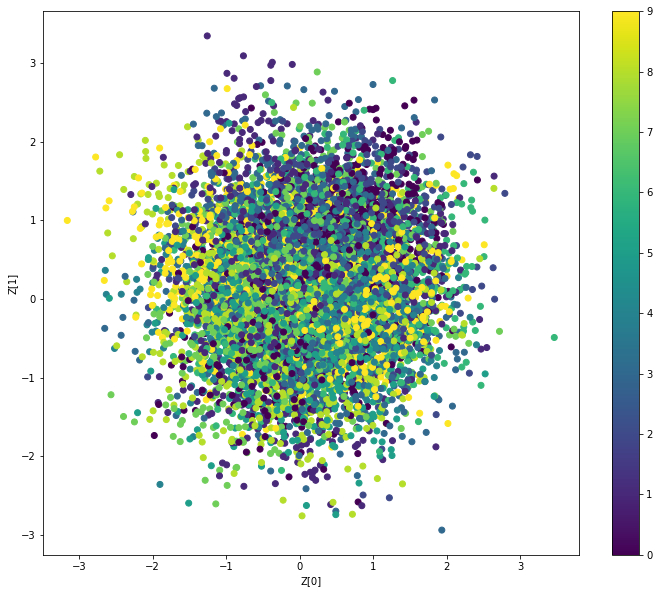

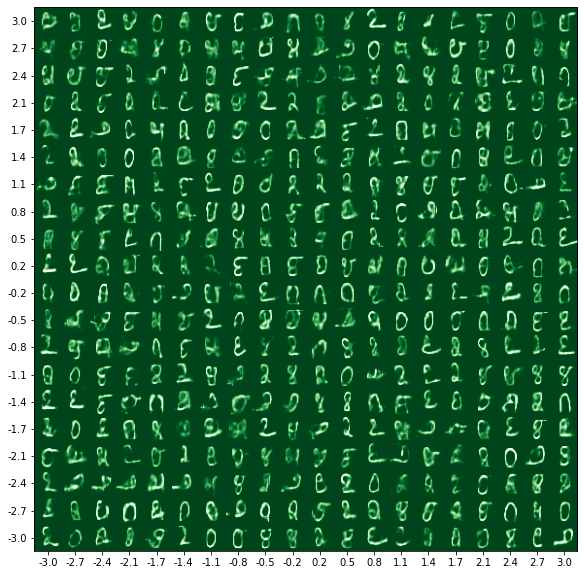

In [8]:
#Create VAE model with 2 code units and generating images by varying each code unit from -3 to 3
intermediate_dim = 256
latent_dim = 16
epochs = 50
vae, encoder, decoder = create_model(intermediate_dim, latent_dim)
trained_model = train_model(vae)
plot_latent_space(encoder)
plot_vae_output(decoder, latent_dim)